In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras

2024-10-17 10:56:32.523966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 0. Introduction

**Dataset**  
- [DSA](https://github.com/MyungKyuYi/AI-class/blob/main/Pre-trained_model.ipynb)

**Environment**
- macOS `x86`cpu

**Framework**  
- TensorFlow: Version `2.10.0`

**Dependencies**  
- Python: Version `3.9.18`
- Numpy: Version `1.26.4`
- Pandas: Version `2.2.2`
- Matplotlib: Version `3.9.2`
- scikit-learn: Version `1.5.1`

**Purpose**
- encoder와 decoder 구조에서의 node 수가 대칭적으로 동일한 Linear Autoencoder를 사용한다.
- 이전에 했던 DSA Autoencoder에서는 `lying`과 `jumping`을 사용했다. 이 둘은 센서 값 차이가 커서 구분이 비교적 쉽다.
- 이번에는 센서 값 차이가 그렇게 크지 않은 `lying`과 `standing`을 사용한다. 이 둘은 센서 값 차이가 비교적 작기 때문에 구분이 어렵다.

**References**
- \-

**Performance(accuracy)**  
- [이전 task: lying과 jumping의 구분]([Github-rudevico](https://github.com/HyoYoonNam/DL-Class/blob/main/assignment/week5_AutoEncoder_DSA.ipynb))
```
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       480

    accuracy                           1.00      1440
   macro avg       1.00      1.00      1.00      1440
weighted avg       1.00      1.00      1.00      1440
```

- [현재 task: lying과 standing의 구분]
```
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       960
           1       0.89      1.00      0.94       480

    accuracy                           0.96      1440
   macro avg       0.94      0.97      0.95      1440
weighted avg       0.96      0.96      0.96      1440

아슬아슬하게 구분이 잘 되었지만, [In] 19를 보면 간당간당한 게 확인된다.
```

# 1. Load the dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv('./datasets/DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [4]:
np.unique(df['activity'])

# 여기서 'lyingBack', 'lyingRigh', 'standing'을 사용한다.

array(['ascendingStairs', 'basketBall', 'crossTrainer',
       'cyclingHorizontal', 'cyclingVertical', 'decendingStairs',
       'jumping', 'lyingBack', 'lyingRigh', 'movingInElevator', 'rowing',
       'runningTreadmill', 'sitting', 'standing',
       'standingInElevatorStill', 'stepper', 'walkingLot',
       'walkingTreadmillFlat', 'walkingTreadmillIncline'], dtype=object)

In [5]:
# lying만 있는 train set
df_train = df[(df['activity'] == 'lyingBack') | (df['activity'] == 'lyingRigh')]
print(f'df_train.shape: {df_train.shape} \ndf_train.unique: {np.unique(df_train["activity"])}')
df_train

df_train.shape: (960, 272) 
df_train.unique: ['lyingBack' 'lyingRigh']


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2.620502,2.6592,2.5891,0.000199,0.014113,0.148452,-9.392025,-9.34240,-9.42070,0.000242,...,0.009589,0.401254,-0.410987,-0.38221,-0.44605,9.935077e-05,0.009967,-0.597598,lyingRigh,p8
1916,2.613423,2.6572,2.5815,0.000207,0.014387,0.368746,-9.398851,-9.36570,-9.43560,0.000156,...,0.008588,0.147180,-0.411248,-0.36581,-0.43676,8.659481e-05,0.009306,1.021454,lyingRigh,p8
1917,2.614750,2.6576,2.5654,0.000257,0.016018,-0.007991,-9.397350,-9.36280,-9.43130,0.000214,...,0.005814,0.032341,-0.409787,-0.37926,-0.43431,7.258946e-05,0.008520,0.431012,lyingRigh,p8
1918,2.620167,2.6589,2.5781,0.000216,0.014691,-0.114904,-9.397014,-9.36490,-9.45390,0.000257,...,0.009510,0.409508,-0.409101,-0.36074,-0.44087,1.127801e-04,0.010620,1.368666,lyingRigh,p8


In [6]:
# 정상 샘플만 있는 X_train
# lyingBack과 lyingRigh를 모두 0(Normal)로 변경
df_train.loc[:, 'activity'] = 0

In [7]:
# X인 동시에 y. self supervised learning
X_train = df_train.drop(['activity', 'people'], axis=1).to_numpy()
print(f'X_train.shape: {X_train.shape}')

X_train.shape: (960, 270)


In [8]:
# lying과 sitting 모두 있는 X_test
df_test = df[(df['activity'] == 'lyingBack') | (df['activity'] == 'lyingRigh') | (df['activity'] == 'standing')]
print(f'df_test.shape: {df_test.shape} \ndf_test.unique: {np.unique(df_test["activity"])}')
df_test

df_test.shape: (1440, 272) 
df_test.unique: ['lyingBack' 'lyingRigh' 'standing']


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
480,8.416815,8.5783,8.3103,0.002356,0.048537,0.867785,0.571528,0.73677,0.35819,0.004036,...,0.001131,0.243260,0.644246,0.64700,0.64109,0.000002,0.001313,-0.184083,standing,p1
481,8.439497,8.6153,8.1908,0.005754,0.075855,0.092156,0.499881,0.63267,0.32807,0.004515,...,0.001678,0.391596,0.643432,0.64789,0.63942,0.000003,0.001805,0.239917,standing,p1
482,8.442786,8.5184,8.3690,0.000786,0.028033,0.096127,0.429967,0.59482,0.32835,0.001260,...,0.001327,0.753549,0.643036,0.64646,0.64019,0.000002,0.001447,0.178525,standing,p1
483,8.444243,8.5480,8.3692,0.001558,0.039470,0.361301,0.414673,0.49073,0.33563,0.000867,...,0.003490,0.178568,0.643370,0.64657,0.64004,0.000003,0.001771,0.080492,standing,p1
484,8.347373,8.4138,8.2791,0.000774,0.027822,0.018596,0.441606,0.52153,0.37246,0.001067,...,0.000940,-0.237978,0.643874,0.64611,0.64063,0.000001,0.001219,-0.291443,standing,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2.620502,2.6592,2.5891,0.000199,0.014113,0.148452,-9.392025,-9.34240,-9.42070,0.000242,...,0.009589,0.401254,-0.410987,-0.38221,-0.44605,0.000099,0.009967,-0.597598,lyingRigh,p8
1916,2.613423,2.6572,2.5815,0.000207,0.014387,0.368746,-9.398851,-9.36570,-9.43560,0.000156,...,0.008588,0.147180,-0.411248,-0.36581,-0.43676,0.000087,0.009306,1.021454,lyingRigh,p8
1917,2.614750,2.6576,2.5654,0.000257,0.016018,-0.007991,-9.397350,-9.36280,-9.43130,0.000214,...,0.005814,0.032341,-0.409787,-0.37926,-0.43431,0.000073,0.008520,0.431012,lyingRigh,p8
1918,2.620167,2.6589,2.5781,0.000216,0.014691,-0.114904,-9.397014,-9.36490,-9.45390,0.000257,...,0.009510,0.409508,-0.409101,-0.36074,-0.44087,0.000113,0.010620,1.368666,lyingRigh,p8


In [9]:
# 정상 sample과 비정상 sample이 모두 있는 X_test
# lyingBack과 lyingRigh를 모두 0(Normal)로 변경
# sitting은 1(Abnormal)로 변경
df_test.loc[df_test['activity'].isin(['lyingBack', 'lyingRigh']), 'activity'] = 0
df_test.loc[df_test['activity'] == 'standing', 'activity'] = 1

# 기존에 y_test는 string value가 있었기 때문에 dtype이 object임
# 이를 위에서 숫자로 바꿔줬어도 object dtype에 숫자를 담을 수 있기에 여전히 object dtype으로 유지
# 이후 연산을 위해서 dtype을 int로 변경
df_test['activity'] = df_test['activity'].astype(int)

/var/folders/m_/5z28qmvj575cs_9xldf0gyd80000gn/T/ipykernel_86589/503677463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['activity'] = df_test['activity'].astype(int)


In [10]:
# test set의 경우 accuracy 평가를 위해서 기존 y를 남겨둠
X_test = df_test.drop(['activity', 'people'], axis=1).to_numpy()
y_test = df_test['activity'].to_numpy()

# # string -> int로 바꾸는 LabelEncoder 사용
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# y_test_labeled = label_encoder.fit_transform(y_test)

# print(f'X_test.shape: {X_test.shape}')
# print(f'Before LabelEncode: {np.unique(df_test["activity"])}')
# print(f'After LabelEncode: {np.unique(y_test_labeled)} \n')
# print(f'y_test_labeled.head() \n{y_test_labeled[:5]}')

# 2. Autoencoder

In [11]:
import tensorflow as tf
import tensorflow.keras as keras

In [12]:
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)
bottleneck_dim = int(encoding_dim / 2)

num_epochs = 50
batch_size = 32

In [13]:
autoencoder = keras.Sequential(name='autoencoder')
# encoder
autoencoder.add(keras.layers.Input(shape=(input_dim,)))
autoencoder.add(keras.layers.Dense(encoding_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(bottleneck_dim, activation='relu'))
# decoder
autoencoder.add(keras.layers.Dense(bottleneck_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(encoding_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

# encoder와 decoder가 대칭적으로 node 수가 동일한 Linear-Autoencoder

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 135)               36585     
                                                                 
 dense_1 (Dense)             (None, 67)                9112      
                                                                 
 dense_2 (Dense)             (None, 67)                4556      
                                                                 
 dense_3 (Dense)             (None, 135)               9180      
                                                                 
 dense_4 (Dense)             (None, 270)               36720     
                                                                 
Total params: 96,153
Trainable params: 96,153
Non-trainable params: 0
_________________________________________________________________


2024-10-17 10:56:36.444229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
autoencoder.compile(optimizer='adam',
                    loss='mse')

In [15]:
history = autoencoder.fit(X_train, X_train,
                          validation_split=0.1,
                          epochs=num_epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          verbose=2)

Epoch 1/50
27/27 - 1s - loss: 5.1959 - val_loss: 4.9389 - 515ms/epoch - 19ms/step
Epoch 2/50
27/27 - 0s - loss: 4.8998 - val_loss: 4.8820 - 54ms/epoch - 2ms/step
Epoch 3/50
27/27 - 0s - loss: 4.8818 - val_loss: 4.8744 - 54ms/epoch - 2ms/step
Epoch 4/50
27/27 - 0s - loss: 4.8638 - val_loss: 4.9044 - 54ms/epoch - 2ms/step
Epoch 5/50
27/27 - 0s - loss: 4.8527 - val_loss: 4.9295 - 55ms/epoch - 2ms/step
Epoch 6/50
27/27 - 0s - loss: 4.8472 - val_loss: 4.9276 - 55ms/epoch - 2ms/step
Epoch 7/50
27/27 - 0s - loss: 4.8399 - val_loss: 4.9229 - 59ms/epoch - 2ms/step
Epoch 8/50
27/27 - 0s - loss: 4.8381 - val_loss: 4.9167 - 51ms/epoch - 2ms/step
Epoch 9/50
27/27 - 0s - loss: 4.8373 - val_loss: 4.9146 - 58ms/epoch - 2ms/step
Epoch 10/50
27/27 - 0s - loss: 4.8368 - val_loss: 4.9171 - 55ms/epoch - 2ms/step
Epoch 11/50
27/27 - 0s - loss: 4.8363 - val_loss: 4.9238 - 53ms/epoch - 2ms/step
Epoch 12/50
27/27 - 0s - loss: 4.8361 - val_loss: 4.9144 - 52ms/epoch - 2ms/step
Epoch 13/50
27/27 - 0s - loss: 4.83

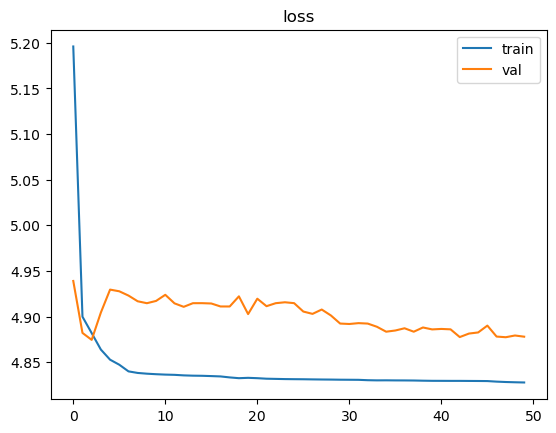

In [16]:
# epoch에 따른 loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label = 'train')
plt.plot(val_loss, label = 'val')
plt.title('loss')
plt.legend() # 우측 상단에 그래프 정보 띄워주는 거
plt.show()

In [17]:
# X_test에 대한 reconstruced data
predictions = autoencoder.predict(X_test) 
# original data와 reconstruced data의 MSE 즉, reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1) 
                                                                                   
# reconstruction error에 따른 Fraud 여부를 저장할 dataframe 생성
error_df = pd.DataFrame({'Reconstruction_error': mse, # reconstruction error와
                        'True_class': y_test})        # 그때의 Jumping 여부

error_df

45/45 [==============================] - 0s 828us/step


,Reconstruction_error,True_class
0,5.130544,1
1,5.085297,1
2,5.135435,1
3,5.070193,1
4,5.070234,1
...,...,...
1435,4.957421,0
1436,4.965448,0
1437,4.964593,0
1438,4.979266,0


In [18]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프를 보고 결정
# 일단 reconstruction error가 25를 넘으면 Jumping로 분류하도록 설정
threshold = 5

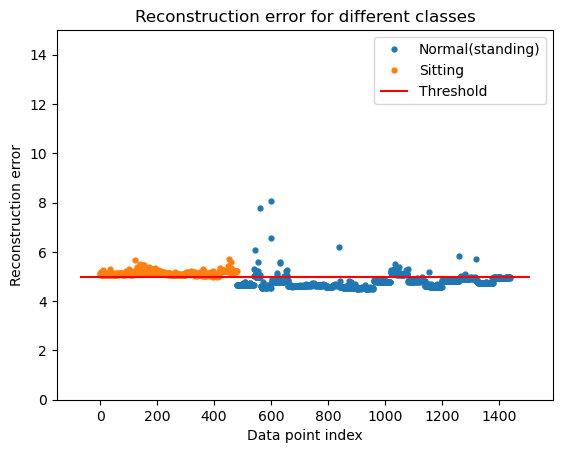

In [19]:
# y값 필터링
# error_df_test = error_df_test.reset_index()

groups = error_df.groupby('True_class')  # True_class별로 그룹화

fig, ax = plt.subplots()

# 각 클래스 그룹에 대해 점들을 플로팅
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Sitting" if name == 1 else "Normal(standing)")

# 고정된 임계값을 빨간 선으로 표시
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Y축 범위를 100 이하로 설정
ax.set_ylim(0, 15)

# 범례, 제목, 축 레이블 설정
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

> lying과 standing의 경우에는 구분이 꽤나 어려운 것을 확인할 수 있음.

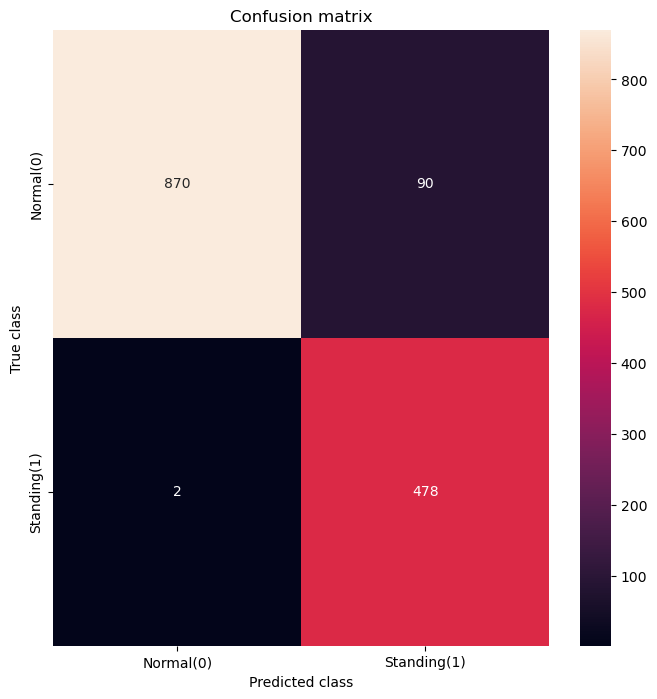

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       960
           1       0.84      1.00      0.91       480

    accuracy                           0.94      1440
   macro avg       0.92      0.95      0.93      1440
weighted avg       0.95      0.94      0.94      1440



In [20]:
from sklearn.metrics import confusion_matrix, classification_report

LABELS = ['Normal(0)', 'Standing(1)']
y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(np.array(error_df.True_class), np.array(y_pred)))

* * *
```cf.
precision   | TP / (TP + FP)
recall      | TP / (TP + FN)
f1-score    | harmonic mean of precision and recall
              (2 * (precision * recall)) / (precision + recall)
              일반적으로 precision과 recall은 trade-off 관계라서 이를 절충할 수 있도록 한 개념임
support     | 각 class의 sample count
accuracy    | (TP + TN) / (TP + TN + FP + FN)
macro avg   | arithmatic mean of precision(각 class들의 precision 평균)
```

```cf.
TN  | True Negative(진음성)
FN  | False Negative(위음성)
FP  | False Positive(위양성)
TP  | True Positive(진양성)
```